# Detección de Fraude en Transacciones Financiera

Grupo: Los deshauciados
- Raúl Calzado Olmo
- José Santos Salvador
- Eugenio Vargas Cabrera
- María Soledad Pérez Urbano
- Jesús Manuel Contreras Herrera

## Descripción breve del problema y del conjunto de datos
El conjunto de datos contiene transacciones realizadas con tarjetas de crédito en septiembre de 2013 por titulares de tarjetas europeos. Este conjunto de datos presenta transacciones ocurridas en dos días, donde se registraron 492 fraudes de un total de 284,807 transacciones. El conjunto de datos está altamente desequilibrado: la clase positiva (fraudes) representa el 0.172% de todas las transacciones.

Solo contiene variables de entrada numéricas, que son el resultado de una transformación PCA (Análisis de Componentes Principales). Desafortunadamente, debido a problemas de confidencialidad, no podemos proporcionar las características originales ni más información de contexto sobre los datos. Las características V1, V2, … V28 son los componentes principales obtenidos con PCA. Las únicas características que no han sido transformadas con PCA son 'Time' y 'Amount'. La característica 'Time' contiene los segundos transcurridos entre cada transacción y la primera transacción del conjunto de datos. La característica 'Amount' es el monto de la transacción, y esta característica puede ser utilizada para aprendizaje dependiente de costos específicos de ejemplos. La característica 'Class' es la variable de respuesta, y toma el valor 1 en caso de fraude y 0 en caso contrario.

## Carga de datos
**Fuente**: https://www.kaggle.com/X_trainsets/mlg-ulb/creditcardfraud

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pyod.models.knn import KNN 

from sklearn.preprocessing import MinMaxScaler

In [2]:


pd.set_option('display.max_columns', None) # elimina el truncado
data = pd.read_csv("./data/creditcard.csv")
print(data.head())


   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10       V11       V12       V13       V14  \
0  0.098698  0.363787  0.090794 -0.551600 -0.617801 -0.991390 -0.311169   
1  0.085102 -0.255425 -0.166974  1.612727  1.065235  0.489095 -0.143772   
2  0.247676 -1.514654  0.207643  0.624501  0.066084  0.717293 -0.165946   
3  0.377436 -1.387024 -0.054952 -0.226487  0.178228  0.507757 -0.287924   
4 -0.270533  0.817739  0.753074 -0.822843  0.538196  1.345852 -1.119670   

        V15       V16       V17       V18       V19       V20 

# Particionamiento en datos de training y de test
Debido al gran desbalanceo que hay en los datos tenemos que asegurarnos que ambas particiones cuentan con clases de los dos tipos.

In [3]:
from sklearn.model_selection import train_test_split


X = data.drop('Class', axis=1)  # Variables independientes
y = data['Class']  # Variable dependiente (class)

# Dividir en entrenamiento y prueba con estratificación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

train_data = pd.concat([X_train, y_train], axis=1)

### Resumen estadistico

In [4]:
print(y_train.value_counts())
print(y_test.value_counts())
#print(X_train.describe())
#print(f"Numero de datos nulos: {X_train.isnull().sum()}")


Class
0    255883
1       443
Name: count, dtype: int64
Class
0    28432
1       49
Name: count, dtype: int64


## Comprobar distribuciones

In [ ]:
def freedman_diaconis_bins(data, feature):
    # Calcular el rango intercuartílico (IQR)
    iqr = np.percentile(data[feature], 75) - np.percentile(data[feature], 25)
    n = len(data[feature])
    
    # Prevenir división por cero
    if iqr == 0:
        return 10  # Valor por defecto si no hay variación
    
    bin_width = 2 * iqr / np.cbrt(n)
    num_bins = int((data[feature].max() - data[feature].min()) / bin_width)
    return max(num_bins, 1)

In [2]:
# Cogemos las variables independientes
independent_variables = [f'V{i}' for i in range(1, 29)]

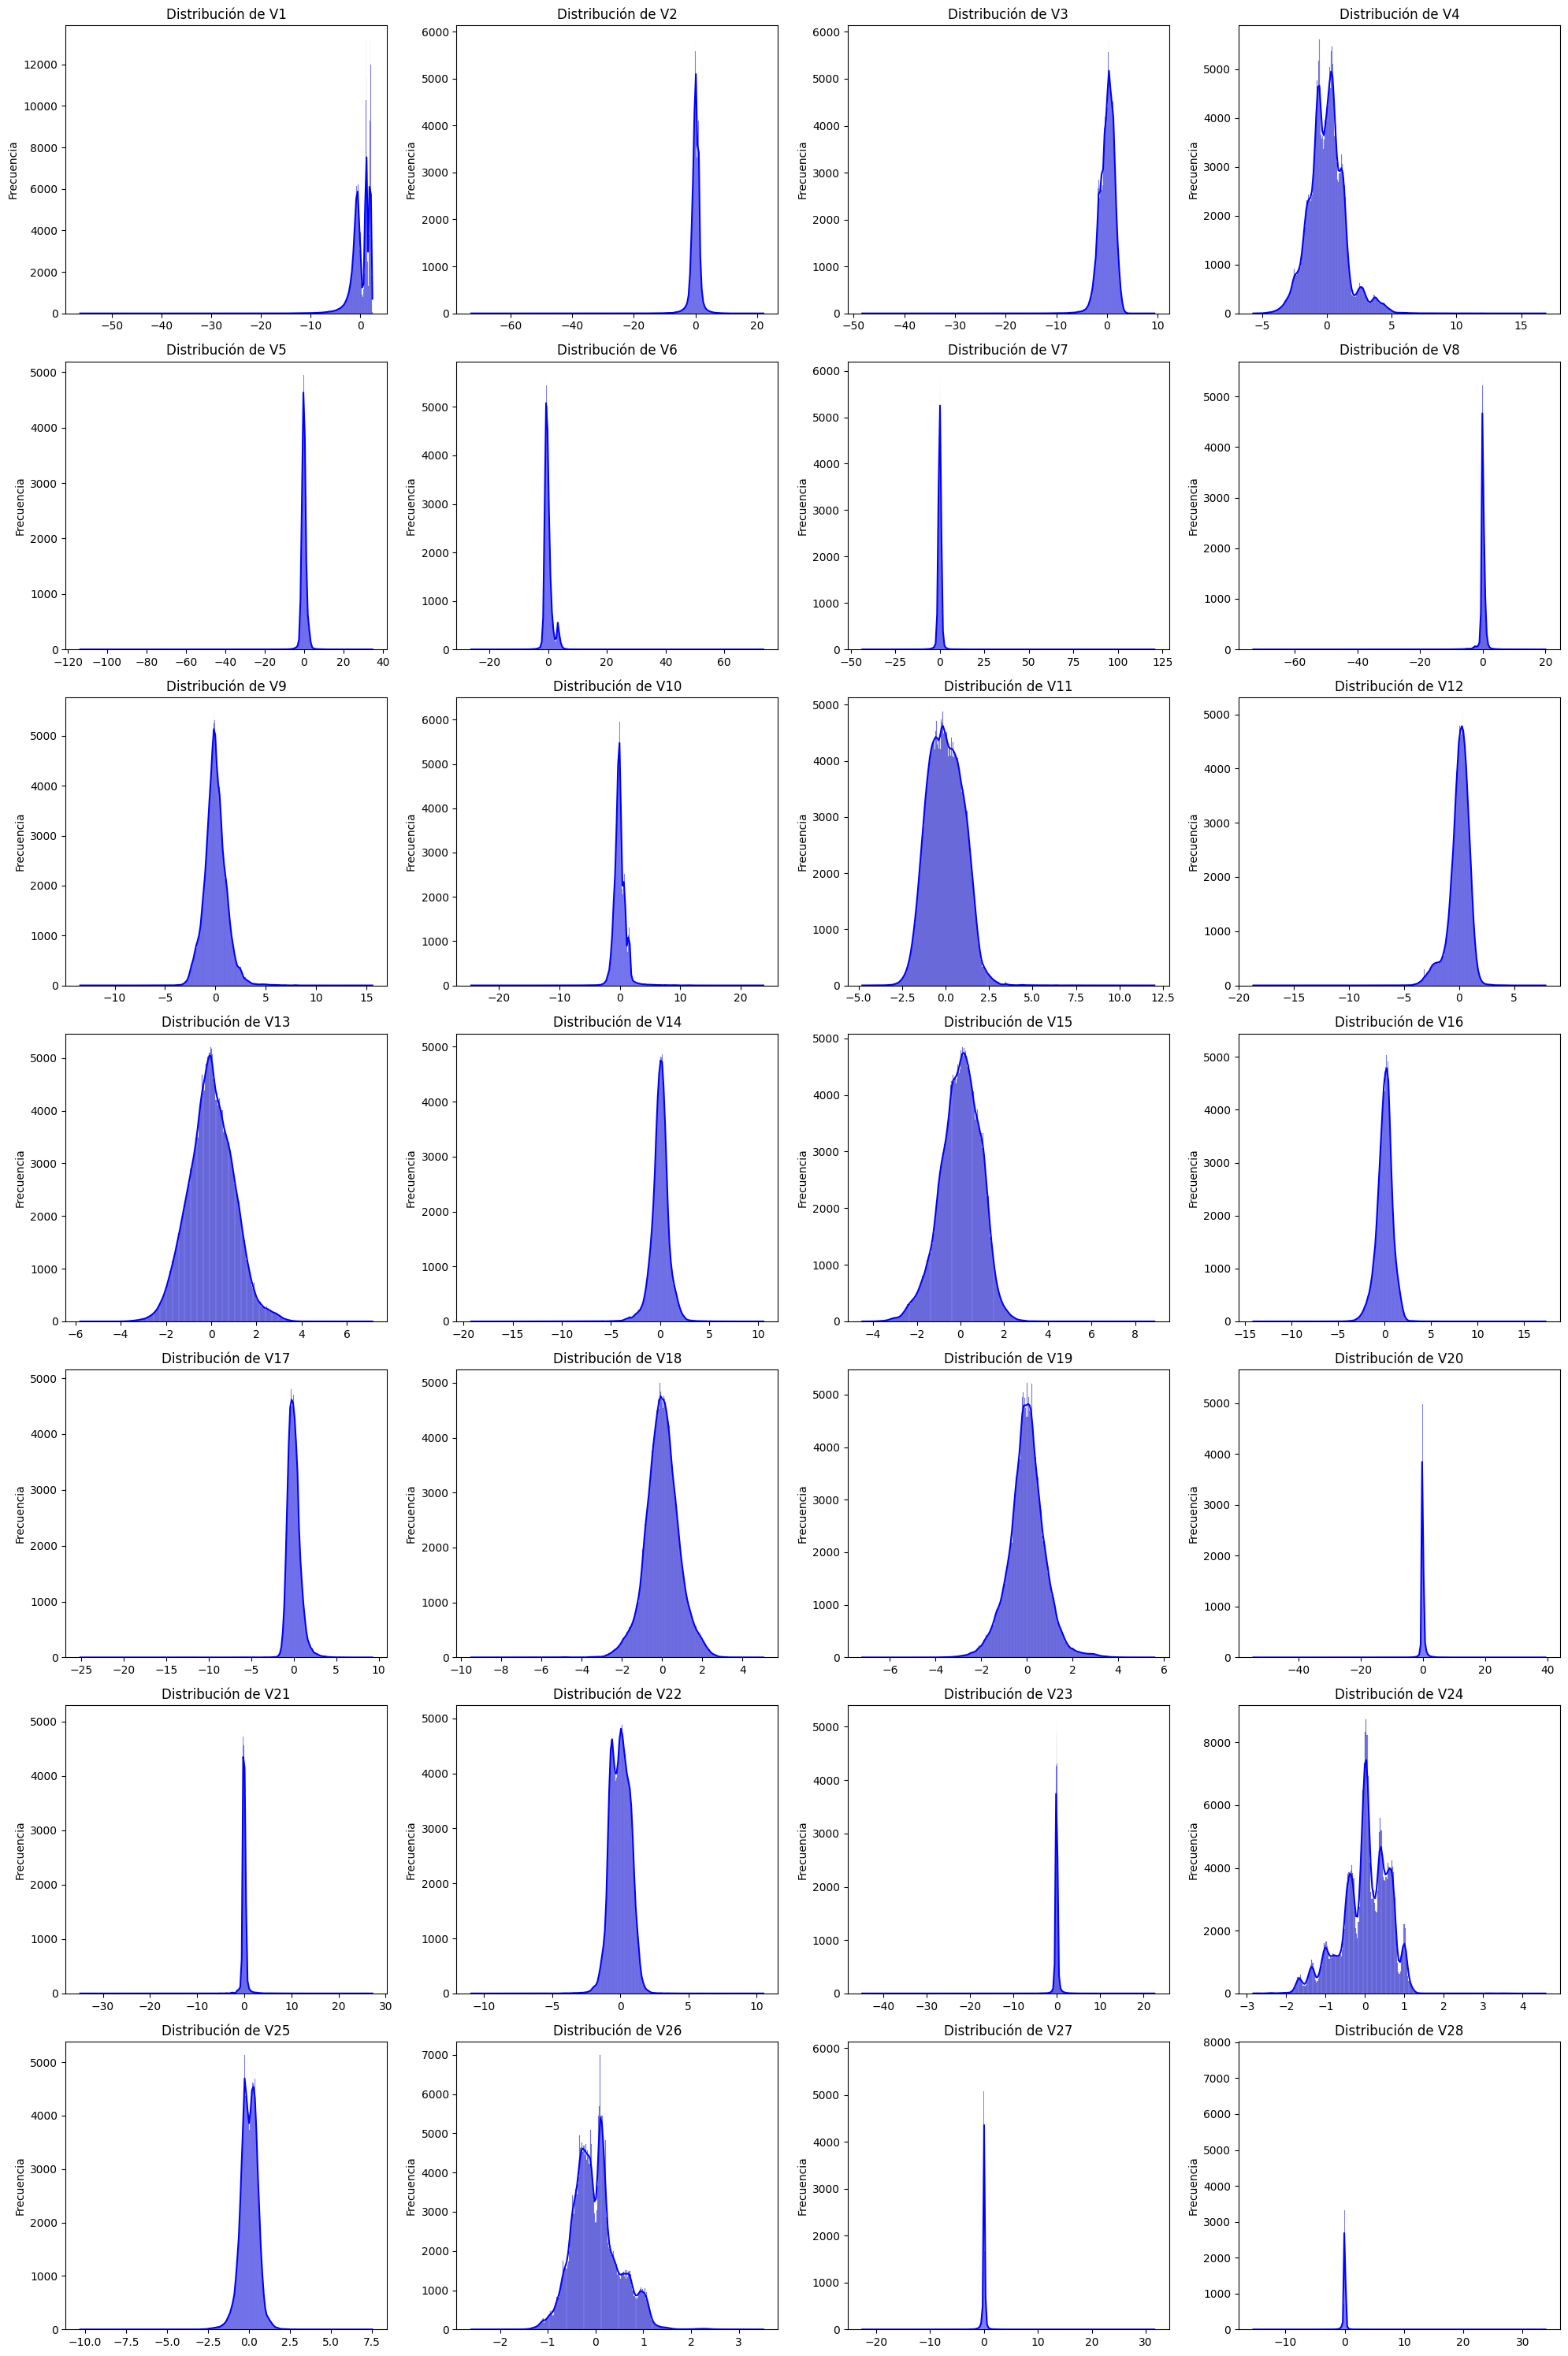

In [ ]:
# Dejo esta parte comentada porque tarda mucho en ejecutarse
# plt.figure(figsize=(20, 30))

# # Crear subgráficos para cada variable de V1 a V28
# for idx, feature in enumerate(independent_variables, 1):
#     plt.subplot(7, 4, idx)
#     bins = freedman_diaconis_bins(X_train, feature) # calculamos los bins basandonos en el rango intercuartilico
#     sns.histplot(X_train[feature], kde=True, bins=bins, color='blue', edgecolor='black')
#     plt.title(f'Distribución de {feature}', fontsize=12)
#     plt.xlabel('')
#     plt.ylabel('Frecuencia')

# plt.tight_layout()
# plt.show()

Como podemos observar los datos de todas las variables independientes ya están normalizadas. Además, no hay datos nulos

### Correlacion de las variables

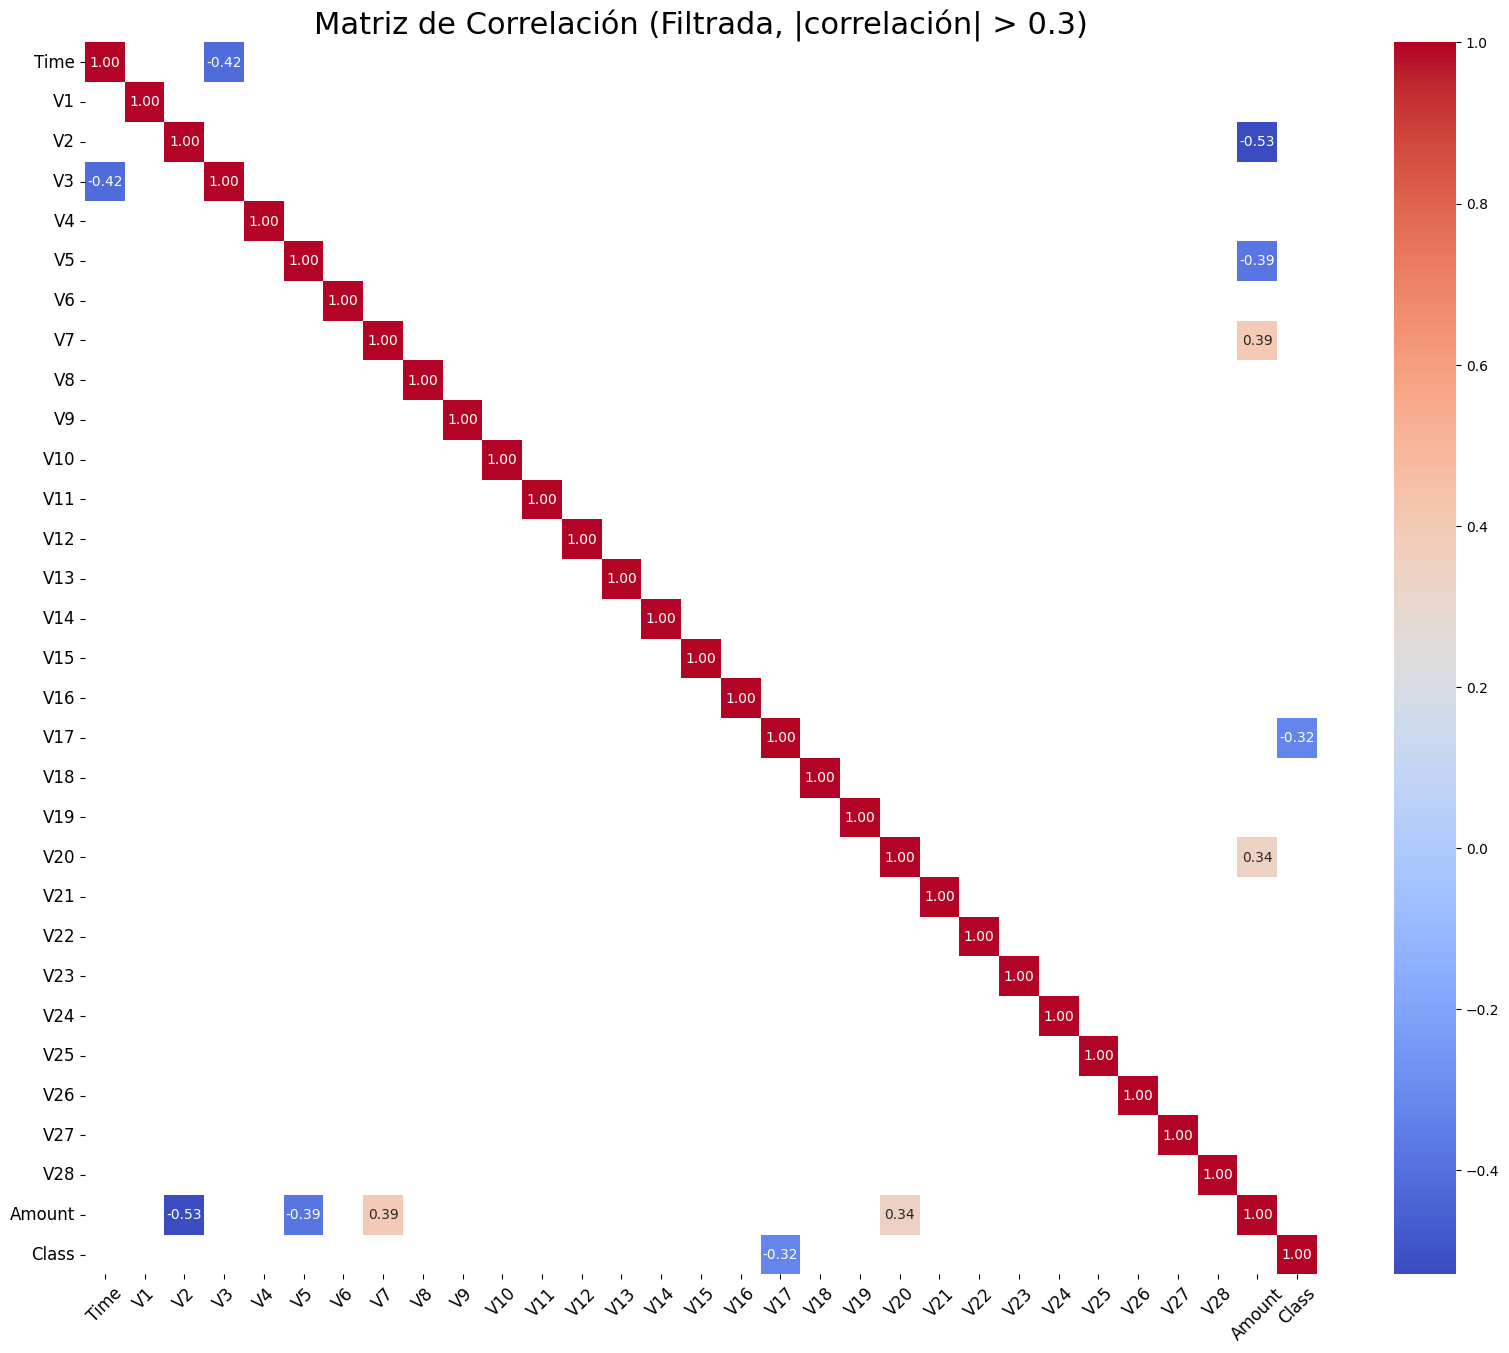

In [10]:

correlation_matrix = train_data.corr()
threshold = 0.3
filtered_corr = correlation_matrix[(correlation_matrix > threshold) | (correlation_matrix < -threshold)]

# Configurar el tamaño del gráfico
plt.figure(figsize=(20, 16))

sns.heatmap(filtered_corr, 
            annot=True,         # Mostrar valores numéricos
            fmt=".2f",          # Limitar a 2 decimales
            cmap="coolwarm",    # Colores del heatmap
            cbar=True,          # Mostrar barra de color
            square=True,        # Hacer celdas cuadradas
            annot_kws={"size": 10},  # Tamaño del texto en las celdas
            mask=np.isnan(filtered_corr))  # Ocultar celdas que no cumplen el umbral

# Título del heatmap
plt.title("Matriz de Correlación (Filtrada, |correlación| > 0.3)", fontsize=22)
plt.xticks(fontsize=12, rotation=45)  # Ajustar tamaño y rotación de las etiquetas del eje X
plt.yticks(fontsize=12, rotation=0) 
plt.show()

Podemos observar que hay correlaciones moderadas:
- Entre Amount y las variables [V2(-), V5(-), V7(+), V20(+)]. ¿¿ELIMINAMOS??
- Entre la variable dependiente Class y la variables independientes V17(-)
- Entre la variable Time y V3(-)



# normalizacion de amount y time

In [4]:



scaler = MinMaxScaler()

# Normalizar las columnas
X_train['Amount'] = scaler.fit_transform(X_train[['Amount']])
X_train['Time'] = scaler.fit_transform(X_train[['Time']])
train_data['Amount'] = scaler.fit_transform(train_data[['Amount']])
train_data['Time'] = scaler.fit_transform(train_data[['Time']])



## Deteccion de anomalias

In [ ]:
# numeric_df = train_data.drop('Class', axis=1)  # Quitamos la columna 'Class' para que no influya en la detección

# # Crear y entrenar el modelo de KNN para detección de anomalías
# model = KNN()
# model.fit(numeric_df)

# # Predecir las anomalías: 0 = normal, 1 = anómalo
# train_data['Anomalía'] = model.predict(numeric_df)

# # Filtrar las filas donde las anomalías se han detectado
# anomalies = train_data[train_data['Anomalía'] == 1]

# # Ahora, vemos si hay fraude en las anomalias
# anomalies_class_1 = anomalies[anomalies['Class'] == 1]

# # Mostrar las anomalías donde ha habido fraude
# print("Anomalías donde 'Class' es 1:")
# print(anomalies_class_1) # el resultado total es 147, por lo que es importante mantener las anomalias, ya que es 1/3 de las transacciones fraudulentas


KeyboardInterrupt: 

## Reduccion de la dimensionalidad

Vamos a establecer el numero de características a 10. Luego iremos probando con un numero mayor o menor para ver si va funcionando mejor
### RFE

In [ ]:
from sklearn.svm import SVC
from sklearn.feature_selection import RFE

#Use a Support Vector Classifier as the base model for feature selection
svc = SVC(kernel="linear", C=1)
#Build a RFE model with the SVC to reduce the number of features of iris to 2
rfe = RFE(estimator=svc, n_features_to_select=10, step=1)
ranking = rfe.fit(X_train, y_train).ranking_
X_reduced_rfe = rfe.fit_transform(X_train, y_train)

print(ranking); print(X_reduced_rfe.shape)
print(X_train.iloc[:10,:])
print("Reduced"); print(X_reduced_rfe[:10,:])

SE PEGA MAS DE 40 MINUTOS

### Seleccion de características backward/fordward

In [ ]:
### MAS DE 450 MINUTOS 

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import BaggingClassifier
import warnings
warnings.filterwarnings('ignore')

bgl = BaggingClassifier(n_estimators=50)

#Perform FORDWARD feature selection over the diabetes dataset to reduce it to 3 dimensions
sfs_forward = SequentialFeatureSelector(bgl, n_features_to_select=10, direction="forward")
sfs_forward_fitted = sfs_forward.fit(X_train, y_train)

X_reduced_for = sfs_forward.transform(X_train)
print(X_reduced_for.shape)
print(sfs_forward_fitted.get_support())
atribs = np.array(X_train.columns)
print("Atributos elegidos")
print(atribs[sfs_forward_fitted.get_support()])

# Comentamos el BACKWARD ya que 10 características las seleccionamos antes usando FORWARD
#Perform BACKWARD feature selection over the diabetes dataset to reduce it to 3 dimensions
# sfs_backward = SequentialFeatureSelector(bgl, n_features_to_select=10, direction="backward")
# sfs_backward_fitted = sfs_backward.fit(X_train, y_train)

# X_reduced_back = sfs_backward_fitted.transform(X_train)
# print(X_reduced_back.shape)
# print(sfs_backward_fitted.get_support())
# print("Atributos elegidos")
# print(atribs[sfs_backward_fitted.get_support()])

### mrMr

In [6]:
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression


n_features_to_select = 10  

# Calcular la información mutua entre cada característica y la variable objetivo (relevancia)
mi = mutual_info_classif(X_train, y_train)

# Inicializar lista de características seleccionadas
selected_features = []
remaining_features = list(range(X_train.shape[1]))

# Seleccionar la primera característica con mayor relevancia (máxima información mutua)
first_feature = np.argmax(mi)
selected_features.append(first_feature)
remaining_features.remove(first_feature)



In [7]:
# Iterativamente seleccionar características usando el criterio MRMR
for _ in range(n_features_to_select - 1):
    mrmr_scores = []
    for feature in remaining_features:
        # Calcular la relevancia (información mutua con la variable objetivo)
        relevance = mi[feature]
        
        # Calcular la redundancia (información mutua con características ya seleccionadas)
        # Modificada 
        redundancy = np.mean([mutual_info_regression(X_train.iloc[:, [feature]], X_train.iloc[:, [sf]])[0] for sf in selected_features])

        
        # MRMR = relevancia - redundancia
        mrmr_score = relevance - redundancy
        mrmr_scores.append((mrmr_score, feature))
    
    # Seleccionar la característica con el puntaje MRMR más alto
    best_feature = max(mrmr_scores, key=lambda x: x[0])[1]
    selected_features.append(best_feature)
    remaining_features.remove(best_feature)



/home/jcontreras/Master/mineriaDeDatosPreprocesamientoYClasificacion/PracticaMineriaDatos/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jcontreras/Master/mineriaDeDatosPreprocesamientoYClasificacion/PracticaMineriaDatos/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jcontreras/Master/mineriaDeDatosPreprocesamientoYClasificacion/PracticaMineriaDatos/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

In [13]:
# Mostrar las características seleccionadas
feature_names = X_train.columns
selected_feature_names = [feature_names[i] for i in selected_features]
print("Características seleccionadas usando MRMR:", selected_feature_names)

Características seleccionadas usando MRMR: ['V17', 'Time', 'Amount', 'V25', 'V20', 'V7', 'V13', 'V22', 'V19', 'V23']


Para 10 características las seleccionadas son los indices [17, 0, 29, 25, 20, 7, 13, 22, 19, 23].

Características seleccionadas usando MRMR: ['V17', 'Time', 'Amount', 'V25', 'V20', 'V7', 'V13', 'V22', 'V19', 'V23']

Ha tardado 45 minutos.
### Random forest

In [16]:
from sklearn.ensemble import RandomForestClassifier


# Cargar el conjunto de datos
feature_names = X_train.columns

# Entrenar el modelo de Random Forest
rf = RandomForestClassifier(n_estimators=50)
rf.fit(X_train, y_train)

# Obtener la importancia de las características
importances = rf.feature_importances_

# Crear un DataFrame con las importancias y ordenar
feature_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("Importancia de características:")
print(feature_importances)

Importancia de características:
   feature  importance
17     V17    0.171796
16     V16    0.103035
12     V12    0.101848
14     V14    0.093131
11     V11    0.077957
10     V10    0.065475
9       V9    0.045053
4       V4    0.034370
18     V18    0.034083
7       V7    0.030577
26     V26    0.019086
20     V20    0.017019
5       V5    0.016471
21     V21    0.015033
3       V3    0.014298
1       V1    0.014219
0     Time    0.013787
29  Amount    0.013290
27     V27    0.012832
19     V19    0.012327
15     V15    0.010768
13     V13    0.010601
28     V28    0.010431
8       V8    0.010071
6       V6    0.010009
2       V2    0.009663
25     V25    0.009243
24     V24    0.008372
22     V22    0.008239
23     V23    0.006919


Las 10 mas importantes: V17,V16,V12,V14,V11,V10,V9,V4,V18,V7

Importancia de características:
   feature  importance
17     V17    0.171796
16     V16    0.103035
12     V12    0.101848
14     V14    0.093131
11     V11    0.077957
10     V10    0.065475
9       V9    0.045053
4       V4    0.034370
18     V18    0.034083
7       V7    0.030577
26     V26    0.019086
20     V20    0.017019
5       V5    0.016471
21     V21    0.015033
3       V3    0.014298
1       V1    0.014219
0     Time    0.013787
29  Amount    0.013290
27     V27    0.012832
19     V19    0.012327
15     V15    0.010768
13     V13    0.010601
28     V28    0.010431
8       V8    0.010071
6       V6    0.010009
2       V2    0.009663
25     V25    0.009243
24     V24    0.008372
22     V22    0.008239
23     V23    0.006919

Observando los resultado anteriores podemos decir que la más importante es V17, aunque el resto varian en gran medida.

### Reducción de instancias

K-means

In [5]:
### Version con mrMr
columns_to_keep_mrmr = ['V17', 'Time', 'Amount', 'V25', 'V20', 'V7', 'V13', 'V22', 'V19', 'V23']
X_train_reduce_mrmr = X_train[columns_to_keep_mrmr]
print(X_train_reduce_mrmr.columns)

Index(['V17', 'Time', 'Amount', 'V25', 'V20', 'V7', 'V13', 'V22', 'V19',
       'V23'],
      dtype='object')


In [7]:
from typing import Counter
from imblearn.under_sampling import ClusterCentroids

#Perform clustering-based prototype generation
cc = ClusterCentroids(random_state=0, voting="soft")
X_resampled, y_resampled = cc.fit_resample(X_train_reduce_mrmr, y_train)

print(sorted(Counter(y_resampled).items()))
reduced = (X.shape[0]-X_resampled.shape[0])/X_train_reduce_mrmr.shape[0]
print(f"Reduce el {100*reduced} %")

[(0, 443), (1, 443)]
Reduce el 110.76558757207617 %


In [ ]:
from typing import Counter
from imblearn.under_sampling import ClusterCentroids

#Perform clustering-based prototype generation
cc = ClusterCentroids(random_state=0, voting="hard")
X_resampled, y_resampled = cc.fit_resample(X_train_reduce_mrmr, y_train)

print(sorted(Counter(y_resampled).items()))
reduced = (X.shape[0]-X_resampled.shape[0])/X_train_reduce_mrmr.shape[0]
print(f"Reduce el {100*reduced} %")

[(0, 443), (1, 443)]
Reduce el 110.76558757207617 %


In [ ]:
df_reduce_mrmr_instances_hard = pd.concat([X_resampled, y_resampled], axis=1)
df_reduce_mrmr_instances_hard.to_csv('./data/df_reduce_mrmr_instances_hard.csv', index=False)

GLVQ

In [9]:
from sklvq import GLVQ

glvq = GLVQ(
    distance_type="squared-euclidean",
    activation_type="swish",
    activation_params={"beta": 2},
    solver_type="steepest-gradient-descent",
    solver_params={"max_runs": 20, "step_size": 0.1},
)

# ajustamos el modelo para que aprenda los prototipos
glvq.fit(X_train_reduce_mrmr, y_train)

/home/jcontreras/Master/mineriaDeDatosPreprocesamientoYClasificacion/PracticaMineriaDatos/.venv/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/jcontreras/Master/mineriaDeDatosPreprocesamientoYClasificacion/PracticaMineriaDatos/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


GLVQ(activation_params={'beta': 2}, activation_type='swish',
     solver_params={'max_runs': 20, 'step_size': 0.1})

In [10]:
# Obtener los prototipos generados por el modelo GLVQ
prototypes = glvq.prototypes_
print(prototypes)

[[ -1.16247126   4.99592563   5.6671113   -0.18912036   2.87605015
   -2.39236559   0.1127342   -0.03651502  -0.32402578   0.50381486]
 [-13.84397567   1.65449461  -0.02786694  -1.52009701   6.17929388
   -9.25012074  -0.22970409   0.7434599    0.42190135   0.93260243]]


Ahora para la version con RandomForestClassifier

In [ ]:
### Version con RandomForestClassifier
columns_to_keep_RFC = ['V17', 'V16', 'V12', 'V14', 'V11', 'V10', 'V9', 'V4', 'V18', 'V7']

X_train_reduce_RFC = X_train[columns_to_keep_RFC]
print(X_train_reduce_RFC.columns)
from typing import Counter
from imblearn.under_sampling import ClusterCentroids

#Perform clustering-based prototype generation
cc_RFC = ClusterCentroids(random_state=0, voting="soft") 
X_resampled_RFC, y_resampled_RFC = cc_RFC.fit_resample(X_train_reduce_RFC, y_train)

print(sorted(Counter(y_resampled_RFC).items()))
reduced = (X.shape[0]-X_resampled_RFC.shape[0])/X_train_reduce_RFC.shape[0]
print(f"Reduce el {100*reduced} %")

cc_RFC = ClusterCentroids(random_state=0, voting="hard") 
X_resampled_RFC_hard, y_resampled_RFC_hard = cc_RFC.fit_resample(X_train_reduce_RFC, y_train)

from sklvq import GLVQ

glvq_RFC = GLVQ(
    distance_type="squared-euclidean",
    activation_type="swish",
    activation_params={"beta": 2},
    solver_type="steepest-gradient-descent",
    solver_params={"max_runs": 20, "step_size": 0.1},
)

# ajustamos el modelo para que aprenda los prototipos
glvq_RFC.fit(X_train_reduce_RFC, y_train)

Index(['V17', 'V16', 'V12', 'V14', 'V11', 'V10', 'V9', 'V4', 'V18', 'V7'], dtype='object')
[(0, 443), (1, 443)]
Reduce el 110.76558757207617 %


/home/jcontreras/Master/mineriaDeDatosPreprocesamientoYClasificacion/PracticaMineriaDatos/.venv/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/jcontreras/Master/mineriaDeDatosPreprocesamientoYClasificacion/PracticaMineriaDatos/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


GLVQ(activation_params={'beta': 2}, activation_type='swish',
     solver_params={'max_runs': 20, 'step_size': 0.1})

guardamos las variables en csv

In [ ]:

train_data.to_csv('./data/train_data.csv', index=False)

# seleccion de caracteristicas
df_reduce_mrmr = pd.concat([X_train_reduce_mrmr, y_train], axis=1)
df_reduce_mrmr.to_csv('./data/X_train_reduce_mrmr.csv', index=False)
#seleccion de caracteristicas e instancias con ClusterCentroids
df_reduce_mrmr_instances = pd.concat([X_resampled, y_resampled], axis=1)
df_reduce_mrmr_instances.to_csv('./data/df_reduce_mrmr_instances.csv', index=False)
#seleccion de caracteristicas e instancias con GLVQ
df_reduce_mrmr_instances_GLVQ = pd.DataFrame(glvq.prototypes_,columns=columns_to_keep_mrmr)
df_reduce_mrmr_instances_GLVQ.to_csv('./data/df_reduce_mrmr_instances_GLVQ.csv', index=False)

# seleccion de caracteristicas
df_X_train_reduce_RFC = pd.concat([X_train_reduce_RFC, y_train], axis=1)
df_X_train_reduce_RFC.to_csv('./data/df_X_train_reduce_RFC.csv', index=False)
#seleccion de caracteristicas e instancias con ClusterCentroids
df_reduce_RFC_instances = pd.concat([X_resampled_RFC, y_resampled_RFC], axis=1)
df_reduce_RFC_instances.to_csv('./data/df_reduce_RFC_instances.csv', index=False)
df_reduce_RFC_instances_hard = pd.concat([X_resampled_RFC_hard, y_resampled_RFC_hard], axis=1)
df_reduce_RFC_instances_hard.to_csv('./data/df_reduce_RFC_instances_hard.csv', index=False)
#seleccion de caracteristicas e instancias con GLVQ
df_reduce_RFC_instances_GLVQ = pd.DataFrame(glvq_RFC.prototypes_, columns=columns_to_keep_RFC)
df_reduce_RFC_instances_GLVQ.to_csv('./data/df_reduce_RFC_instances_GLVQ.csv', index=False)
